In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import gc
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
d_input = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, (4, 4), strides=2, padding="same")(d_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(64, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(64, (4, 4), strides=2, padding="same")(x)
x = layers.LeakyReLU(alpha=0.2)(x)
features = layers.Flatten()(x)
x = layers.Dropout(0.2)(features)
x = layers.Dense(1, activation="sigmoid")(x)

discriminator = Model(d_input, x, name='discriminator')
feature_model = Model(d_input, features, name='feature_model')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        1568      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 64)          32832     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          65600     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 4, 4, 64)        

In [ ]:
generator = tf.keras.Sequential(
    [
        layers.Input(shape=(64,)),
        layers.Dense(1024),
        layers.Reshape((4, 4, 64)),
        layers.Conv2DTranspose(64, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, (4, 4), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name='generator'
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              66560     
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 8, 8, 64)         65600     
 ranspose)                                                       
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 64)       65600     
 Transpose)                                                      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 16, 16, 64)        0 

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # print(real_images.shape)
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=64)

In [ ]:
gc.collect()

56714

In [ ]:
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

h = gan.fit(
    x_train,
    epochs=75,
    batch_size=128,
    shuffle=True,
)

Epoch 1/75
391/391 [==============================] - 13s 23ms/step - d_loss: 0.5457 - g_loss: 1.2588
Epoch 2/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.5543 - g_loss: 1.1389
Epoch 3/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.6082 - g_loss: 1.1938
Epoch 4/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.5398 - g_loss: 1.3659
Epoch 5/75
391/391 [==============================] - 9s 24ms/step - d_loss: 0.6061 - g_loss: 1.1628
Epoch 6/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.6173 - g_loss: 0.9423
Epoch 7/75
391/391 [==============================] - 9s 22ms/step - d_loss: 0.6391 - g_loss: 1.0010
Epoch 8/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.5946 - g_loss: 1.0939
Epoch 9/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.5655 - g_loss: 1.3175
Epoch 10/75
391/391 [==============================] - 9s 23ms/step - d_loss: 0.5452 - g_l

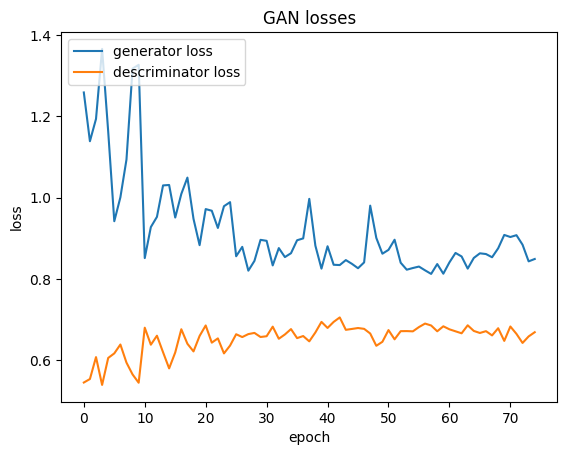

In [ ]:
from matplotlib import pyplot as plt
plt.plot(h.history['g_loss'])
plt.plot(h.history['d_loss'])
plt.title('GAN losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator loss', 'descriminator loss'], loc='upper left')
plt.show()

In [ ]:
test = tf.random.normal(shape=(10, 64))

In [ ]:
fake = gan.generator(test)

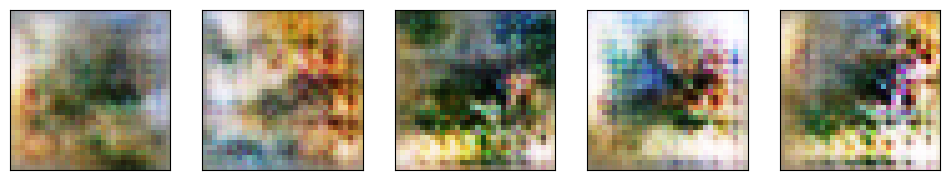

In [ ]:
def display(x1):
    n = 5  # How many digits we will display
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x1[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

display(fake)

In [ ]:
features = feature_model(x_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(features, y_train)

<ipython-input-74-91d036876d26>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(features, y_train)


RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
test_features = feature_model(x_test)

In [ ]:
y_pred = clf.predict(test_features)

In [ ]:
accuracy_score(y_test, y_pred)

0.4281